In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def ler_arquivo(arquivo):
    # Lendo o arquivo com pandas
    df = pd.read_csv(arquivo, delimiter=r'\s+')
    
    # Renomeando as colunas
    colunas = {
        'time': 'tempo',
        'target_qps': 'qps_alvo',
        'actual_qps': 'qps_real',
        'responses_per_sec': 'respostas_por_seg',
        'failures_per_sec': 'falhas_por_seg',
        'avg_latency': 'latencia_media',
        'connections': 'conexoes',
        'conn_avg_latency': 'latencia_media_conexoes'
    }
    df = df.rename(columns=colunas)
    
    # Convertendo tempo para segundos
    df['tempo'] = df['tempo'] / 1000
    
    # Calculando a diferença percentual
    df['diferenca_percentual'] = abs((df['qps_real'] - df['qps_alvo']) / df['qps_alvo'] * 100)
    
    return df

def encontrar_ponto_divergencia(df, limiar=2):
    # Encontrando o ponto onde a diferença percentual excede o limiar
    return df[df['diferenca_percentual'] > limiar].iloc[0]

# Lendo os arquivos
df_no = ler_arquivo('../../Python/20241224-dnsfw_no.gnuplot')
df_xdp = ler_arquivo('../../Python/20241224-dnsfw_xdp.gnuplot')
df_rpz = ler_arquivo('../../Python/20241224-dnsfw_rpz.gnuplot')

# Encontrando pontos de divergência
ponto_div_no = encontrar_ponto_divergencia(df_no)
ponto_div_xdp = encontrar_ponto_divergencia(df_xdp)
ponto_div_rpz = encontrar_ponto_divergencia(df_rpz)

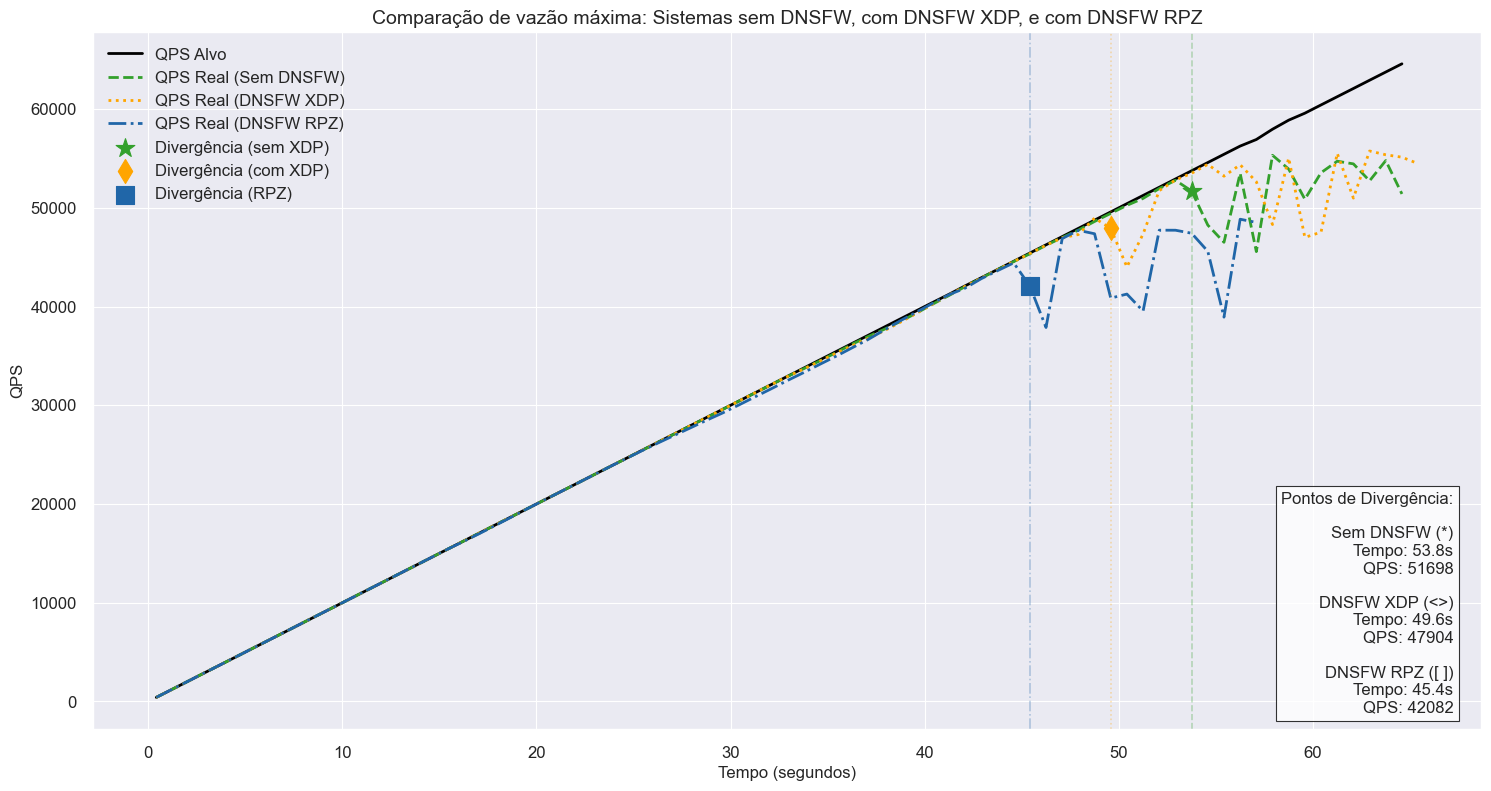

In [23]:
# Criando o gráfico
fig, ax = plt.subplots(figsize=(15, 8))

plt.style.use('seaborn-v0_8')
sns.set_context("paper")
sns.set_style("darkgrid")

# Plotando dados com diferentes estilos de linha
ax.plot(df_no['tempo'], df_no['qps_alvo'], 
        label='QPS Alvo', 
        color='black', 
        linestyle='-', 
        linewidth=2)

ax.plot(df_no['tempo'], df_no['qps_real'], 
        label='QPS Real (Sem DNSFW)', 
        color='#33A02C', 
        linestyle='--', 
        linewidth=2)

ax.plot(df_xdp['tempo'], df_xdp['qps_real'], 
        label='QPS Real (DNSFW XDP)', 
        color='#FFA500', 
        linestyle=':', 
        linewidth=2)

ax.plot(df_rpz['tempo'], df_rpz['qps_real'], 
        label='QPS Real (DNSFW RPZ)', 
        color='#2066A8', 
        linestyle='-.', 
        linewidth=2)

# Destacando pontos de divergência com diferentes marcadores
ax.scatter(ponto_div_no['tempo'], ponto_div_no['qps_real'], 
          marker='*',  # Estrela
          s=200, 
          color='#33A02C', 
          zorder=5, 
          label='Divergência (sem XDP)')

ax.scatter(ponto_div_xdp['tempo'], ponto_div_xdp['qps_real'], 
          marker='d',  # Diamante
          s=150, 
          color='#FFA500', 
          zorder=5, 
          label='Divergência (com XDP)')

ax.scatter(ponto_div_rpz['tempo'], ponto_div_rpz['qps_real'], 
          marker='s',  # Quadrado
          s=150, 
          color='#2066A8', 
          zorder=5, 
          label='Divergência (RPZ)')

# Adicionando linhas verticais com diferentes padrões
ax.axvline(x=ponto_div_no['tempo'], color='#33A02C', linestyle='--', alpha=0.3)
ax.axvline(x=ponto_div_xdp['tempo'], color='#FFA500', linestyle=':', alpha=0.3)
ax.axvline(x=ponto_div_rpz['tempo'], color='#2066A8', linestyle='-.', alpha=0.3)

# Configurando o gráfico
ax.set_xlabel('Tempo (segundos)', fontsize=12)
ax.set_ylabel('QPS', fontsize=12)
ax.tick_params(axis='both', labelsize=12) 
ax.set_title('Comparação de vazão máxima: Sistemas sem DNSFW, com DNSFW XDP, e com DNSFW RPZ', fontsize=14)
ax.legend(loc='upper left', fontsize=12)
#ax.grid(True, linestyle='-', alpha=0.3, linewidth=2, color='white')

# Criando uma caixa de texto no canto inferior direito
text_box = (
    f'Pontos de Divergência:\n\n'
    f'Sem DNSFW (*)\n'
    f'Tempo: {ponto_div_no["tempo"]:.1f}s\n'
    f'QPS: {ponto_div_no["qps_real"]:.0f}\n\n'
    f'DNSFW XDP (<>)\n'
    f'Tempo: {ponto_div_xdp["tempo"]:.1f}s\n'
    f'QPS: {ponto_div_xdp["qps_real"]:.0f}\n\n'
    f'DNSFW RPZ ([ ])\n'
    f'Tempo: {ponto_div_rpz["tempo"]:.1f}s\n'
    f'QPS: {ponto_div_rpz["qps_real"]:.0f}'
)

# Adicionando a caixa de texto
plt.text(0.98, 0.02, text_box,
         transform=ax.transAxes,
         bbox=dict(facecolor='white', edgecolor='black', alpha=0.8),
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=12)

plt.tight_layout()

# Salvando com configurações completas
plt.savefig('vazao_sistemas.png',
            dpi=300,              # resolução
            bbox_inches='tight',  # remove espaço em branco extra
            pad_inches=0.1,       # pequena margem
            format='png',         # formato do arquivo
            transparent=False,    # fundo não transparente
#            facecolor='dimgray',    # cor do fundo
            edgecolor='none',     # sem borda
            )

plt.show()



In [8]:
# Imprimindo informações sobre os pontos de divergência
print("\nPonto de Divergência (sem XDP):")
print(f"Tempo: {ponto_div_no['tempo']:.1f} segundos")
print(f"QPS Alvo: {ponto_div_no['qps_alvo']:.0f}")
print(f"QPS Real: {ponto_div_no['qps_real']:.0f}")
print(f"Diferença: {ponto_div_no['diferenca_percentual']:.1f}%")

print("\nPonto de Divergência (com XDP):")
print(f"Tempo: {ponto_div_xdp['tempo']:.1f} segundos")
print(f"QPS Alvo: {ponto_div_xdp['qps_alvo']:.0f}")
print(f"QPS Real: {ponto_div_xdp['qps_real']:.0f}")
print(f"Diferença: {ponto_div_xdp['diferenca_percentual']:.1f}%")

print("\nPonto de Divergência (RPZ):")
print(f"Tempo: {ponto_div_rpz['tempo']:.1f} segundos")
print(f"QPS Alvo: {ponto_div_rpz['qps_alvo']:.0f}")
print(f"QPS Real: {ponto_div_rpz['qps_real']:.0f}")
print(f"Diferença: {ponto_div_rpz['diferenca_percentual']:.1f}%")


Ponto de Divergência (sem XDP):
Tempo: 53.8 segundos
QPS Alvo: 53750
QPS Real: 51698
Diferença: 3.8%

Ponto de Divergência (com XDP):
Tempo: 49.6 segundos
QPS Alvo: 49582
QPS Real: 47904
Diferença: 3.4%

Ponto de Divergência (RPZ):
Tempo: 45.4 segundos
QPS Alvo: 45418
QPS Real: 42082
Diferença: 7.3%
